In [1]:
import os

import tensorflow as tf
print(tf.version.VERSION)

import tensorflow.keras.layers as layers

from sklearn.model_selection import train_test_split

import albumentations as A
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2.10.0


# Load dataset

In [2]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [4]:
X_train, X_test, y_train, y_test = \
    train_test_split(images, labels, test_size=0.1)

# make dataset from the list
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# set batch_size na 32 and shuffle 1000
train_ds = train_ds.shuffle(1000).batch(32)

In [5]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]

# Define base model

In [6]:
# Define a simple sequential model
def create_model():
  model = tf.keras.models.Sequential([
      layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
      layers.Dense(512, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 575,050
Trainable params: 575,050
Non-trai

# Train base model

In [7]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_hist = model.fit(train_ds,
                       epochs=7,
                       batch_size=batch_size,
                       validation_data=(X_test, y_test),
                       callbacks=[cp_callback]) # Pass callback to training  
                    

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.


# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')

Epoch 1/7
 149/1688 [=>............................] - ETA: 4s - loss: 0.8086 - sparse_categorical_accuracy: 0.7051
Epoch 1: saving model to training_2\cp-0001.ckpt
 318/1688 [====>.........................] - ETA: 5s - loss: 0.6872 - sparse_categorical_accuracy: 0.7486
Epoch 1: saving model to training_2\cp-0001.ckpt
 478/1688 [=======>......................] - ETA: 4s - loss: 0.6259 - sparse_categorical_accuracy: 0.7716
Epoch 1: saving model to training_2\cp-0001.ckpt
 619/1688 [==========>...................] - ETA: 3s - loss: 0.5980 - sparse_categorical_accuracy: 0.7826
Epoch 1: saving model to training_2\cp-0001.ckpt
 786/1688 [============>.................] - ETA: 3s - loss: 0.5692 - sparse_categorical_accuracy: 0.7938
Epoch 1: saving model to training_2\cp-0001.ckpt
 943/1688 [===============>..............] - ETA: 2s - loss: 0.5512 - sparse_categorical_accuracy: 0.8013
Epoch 1: saving model to training_2\cp-0001.ckpt
1113/1688 [==================>...........] - ETA: 2s - loss:

In [8]:
model_hist.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

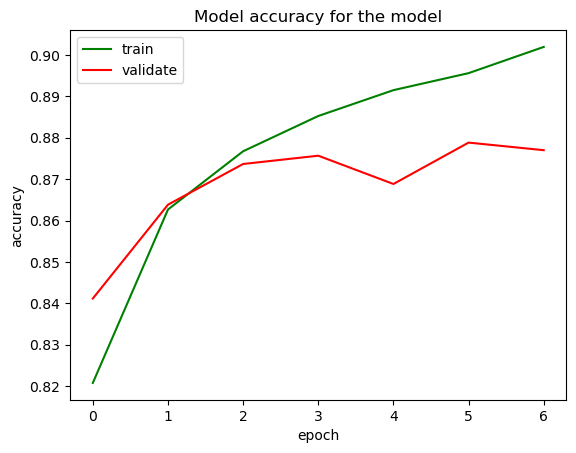

In [9]:
#Plot accuracy results for training data and testing data 
plt.plot(model_hist.history['sparse_categorical_accuracy'], 'green')
plt.plot(model_hist.history['val_sparse_categorical_accuracy'], 'red')
plt.title('Model accuracy for the model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

In [10]:
# Recreate the exact same model, including its weights and the optimizer
my_model = tf.keras.models.load_model('my_model.h5')
loss, acc = my_model.evaluate(X_test, y_test, verbose=2)
results = my_model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

188/188 - 0s - loss: 0.3519 - sparse_categorical_accuracy: 0.8770 - 453ms/epoch - 2ms/step
47/47 [==============================] - 0s 2ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.8770
test loss, test acc: [0.3519418239593506, 0.8769999742507935]


# Check Prediction

In [11]:
def check(model, x, n):
    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
              'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    y_pred = model.predict(x)
    
    imgplot = plt.imshow(X_test[n])
    plt.show()
    print(f"Model predicts: {labels[np.argmax(y_pred[n])]} - {np.argmax(y_pred[n])}/{y_test[n]}")

188/188 [==============================] - 0s 965us/step


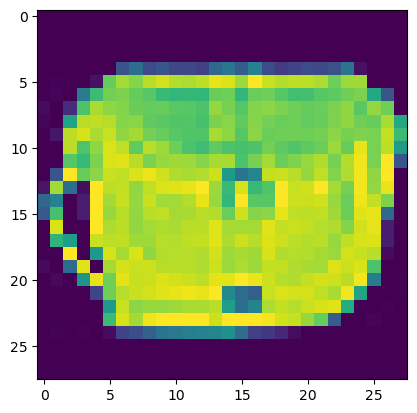

Model predicts: Bag - 8/8


In [12]:
check(model, X_test, 1)

# Preparation of additional data -  albumentations library

In [13]:
from PIL import Image
from matplotlib import cm
im = Image.fromarray(np.uint8(cm.gist_earth(X_test[0])*255))

In [14]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(28, 28))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(Image.fromarray(np.uint8(cm.gist_earth(image[i])*255)))
        ax.set_title(f"Label: {label[i]}")

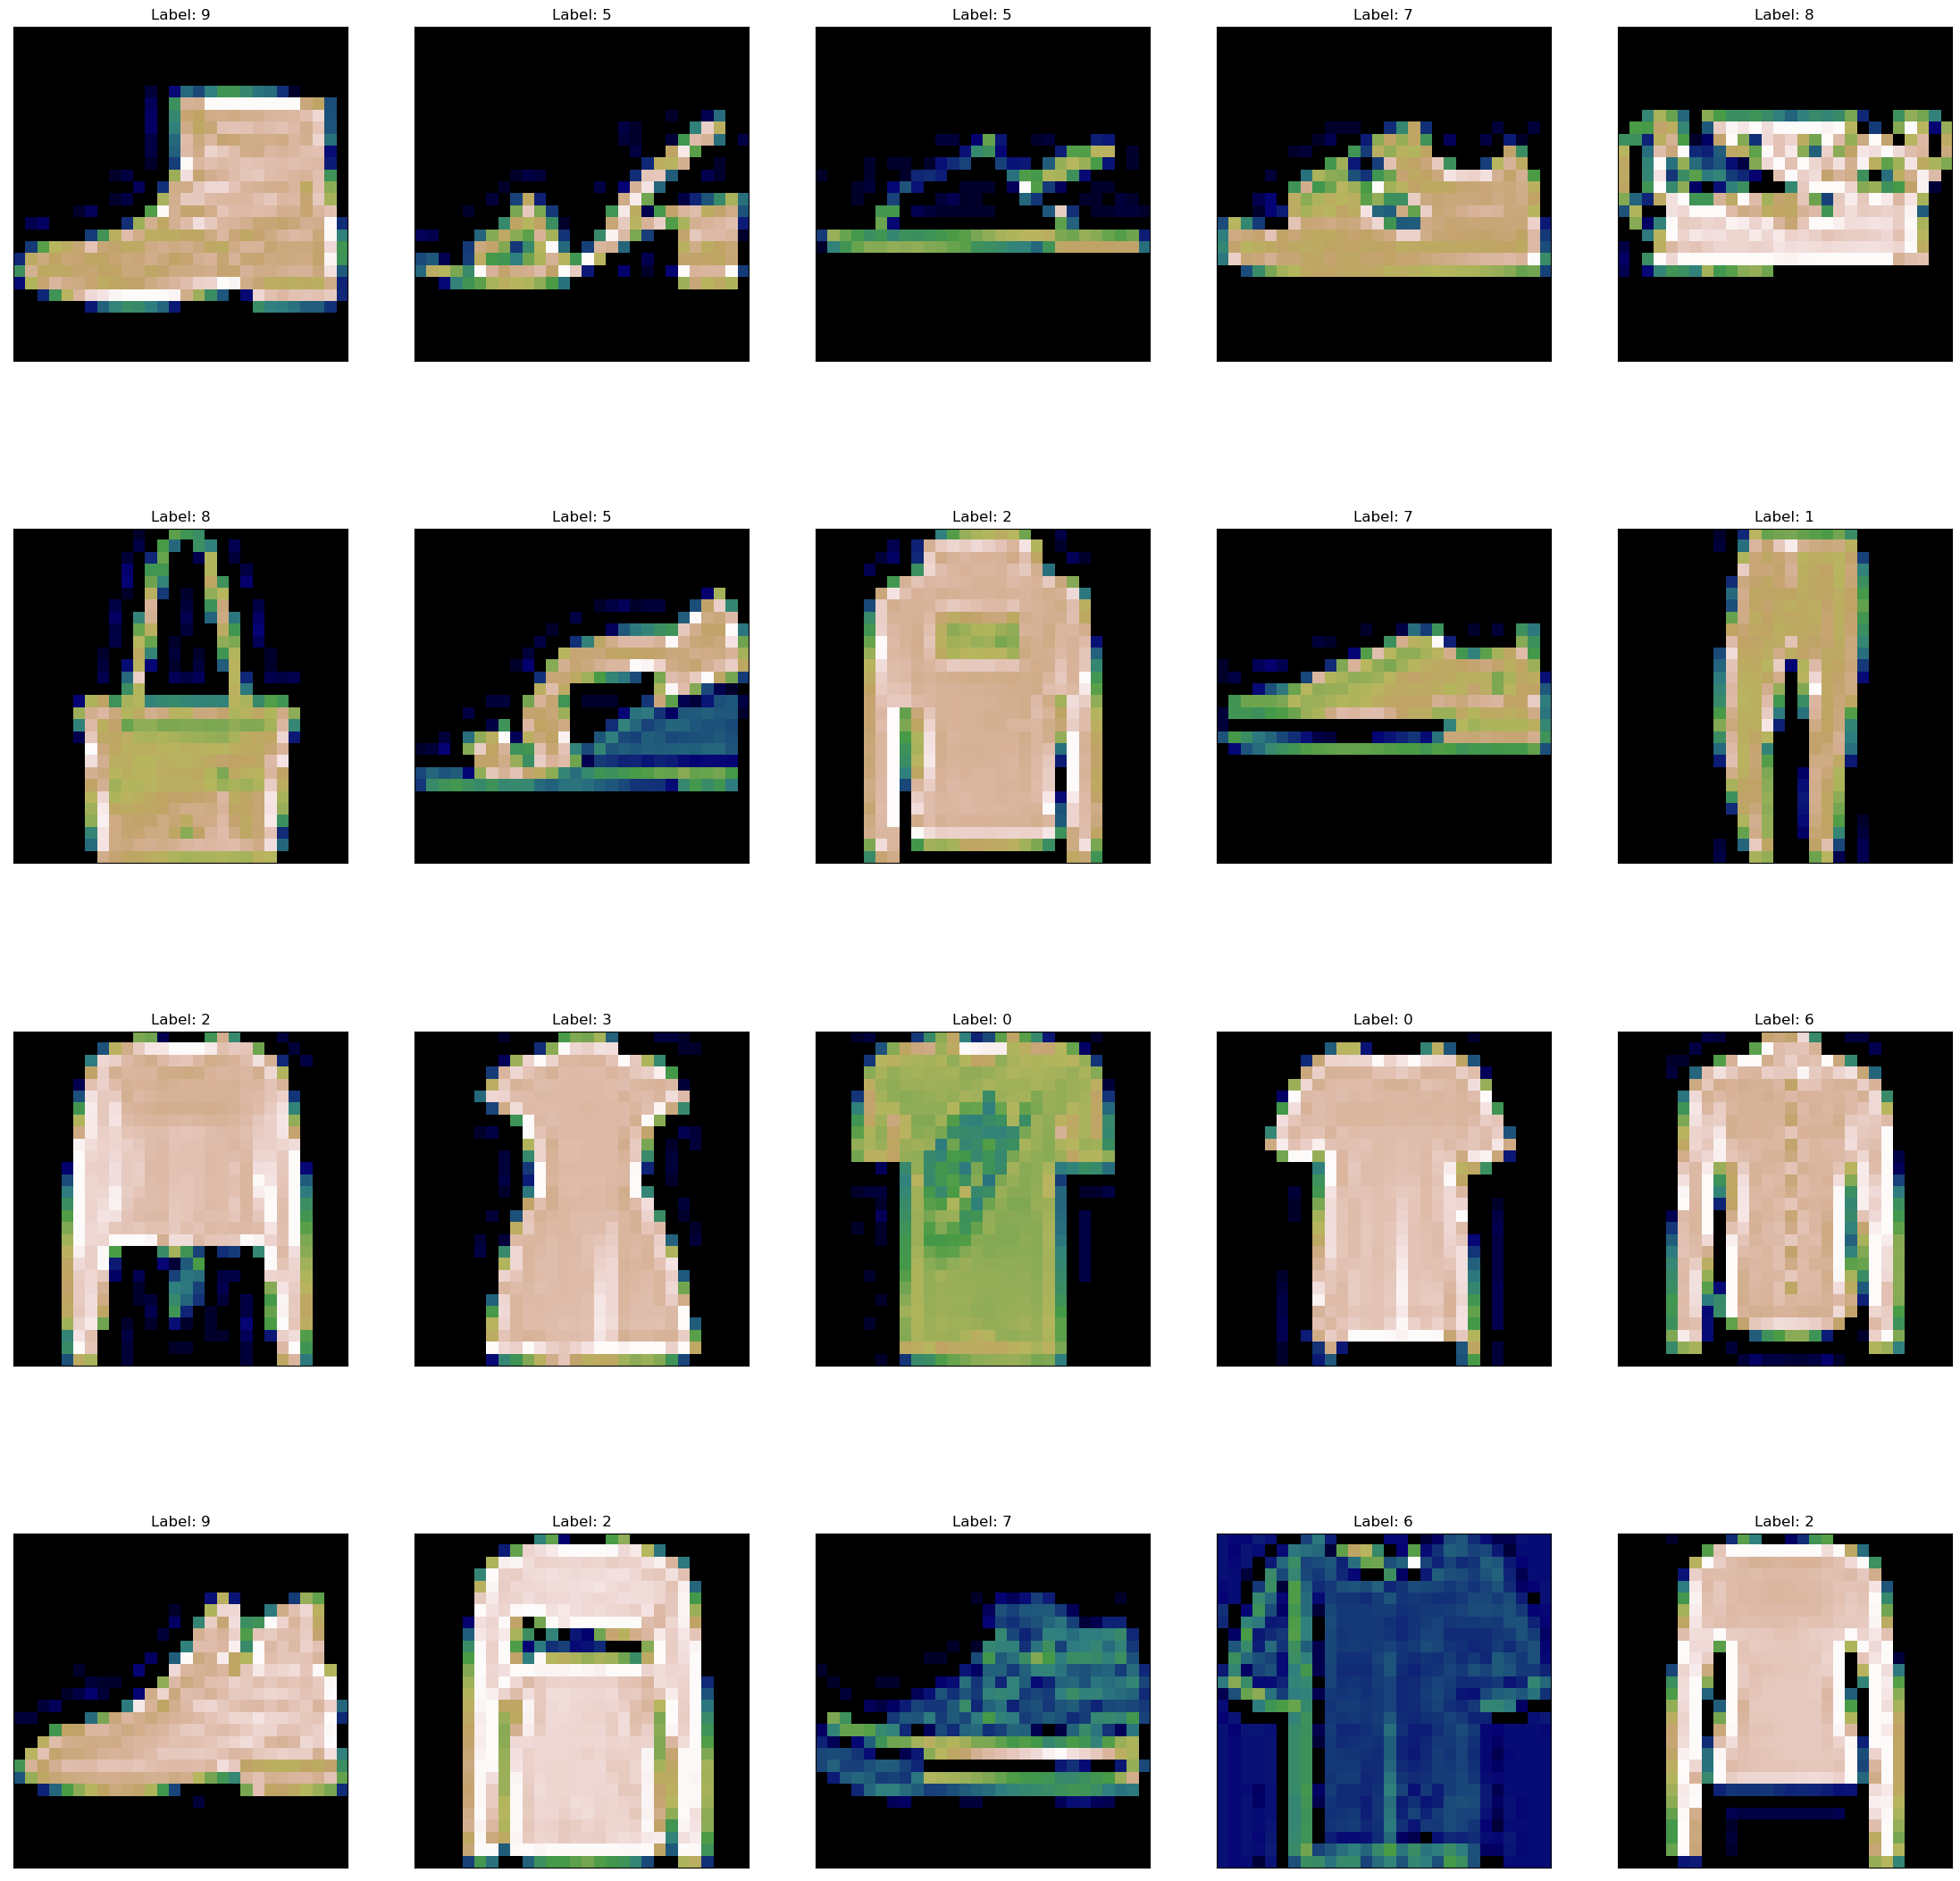

In [15]:
view_image(train_ds)

In [16]:
# necessary imports
import albumentations as A

In [17]:
images, labels = train
images = images/ 255
labels = labels.astype(np.int32)

In [18]:
image = X_test[3]

In [19]:
def visualize(image):
    plt.figure(figsize=(1, 1), dpi=75)
    plt.axis('off')
    plt.imshow(image)

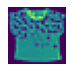

In [20]:
from skimage import img_as_ubyte
cv_image = img_as_ubyte(image)
visualize(cv_image)

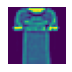

In [69]:
transform = A.Compose([
        A.OneOf([
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MedianBlur(blur_limit=1, p=0.3),
        ], p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0, p=0.3),
    ])
np.random.seed(42) 
augmented_image = transform(image=cv_image)['image']
visualize(augmented_image)

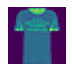

In [70]:
cv_image = img_as_ubyte(X_train[3])
visualize(cv_image)

In [71]:
def new_dataset(x):
    X_train = []

    for image in x:
        cv_image = img_as_ubyte(image)
        augmented_image = transform(image=cv_image)['image']
        X_train.append(augmented_image)
        
    return X_train

In [72]:
size = 100
r = np.random.randint(0,size)
X_add = np.split(X_train,size,axis=0)[r]
y_add = np.split(y_train,size,axis=0)[r]

In [73]:
new_X_train = new_dataset(X_add)

In [74]:
X_old_and_new = np.concatenate((new_X_train, X_train), axis=0)

In [75]:
y_old_and_new = np.concatenate((y_add, y_train), axis=0)

In [76]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
              'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

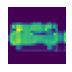

In [77]:
visualize(X_old_and_new[1])

In [78]:
labels[y_add[1]]

'Bag'

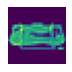

In [79]:
visualize(X_add[1])

# Training new model on expanded dataset

In [80]:
# make dataset from the list
train_ds = tf.data.Dataset.from_tensor_slices((X_old_and_new, y_old_and_new))

# set batch_size na 32 and shuffle 1000
old_and_new_train_ds = train_ds.shuffle(1000).batch(32)

In [81]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
model_v2 = create_model()

# Save the weights using the `checkpoint_path` format
model_v2.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model_hist = model_v2.fit(old_and_new_train_ds,
                       epochs=10,
                       batch_size=batch_size,
                       validation_data=(X_test, y_test),
                       callbacks=[cp_callback]) # Pass callback to training  
                    

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.


# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model_v2.h5')

Epoch 1/10
 142/1705 [=>............................] - ETA: 8s - loss: 5.0628 - sparse_categorical_accuracy: 0.5002
Epoch 1: saving model to training_3\cp-0001.ckpt
 297/1705 [====>.........................] - ETA: 6s - loss: 2.9773 - sparse_categorical_accuracy: 0.5682
Epoch 1: saving model to training_3\cp-0001.ckpt
 463/1705 [=======>......................] - ETA: 4s - loss: 2.1310 - sparse_categorical_accuracy: 0.6430
Epoch 1: saving model to training_3\cp-0001.ckpt
 632/1705 [==========>...................] - ETA: 4s - loss: 1.7106 - sparse_categorical_accuracy: 0.6828
Epoch 1: saving model to training_3\cp-0001.ckpt
 791/1705 [============>.................] - ETA: 3s - loss: 1.4658 - sparse_categorical_accuracy: 0.7121
Epoch 1: saving model to training_3\cp-0001.ckpt
 947/1705 [===============>..............] - ETA: 2s - loss: 1.3066 - sparse_categorical_accuracy: 0.7298
Epoch 1: saving model to training_3\cp-0001.ckpt
1116/1705 [==================>...........] - ETA: 2s - loss

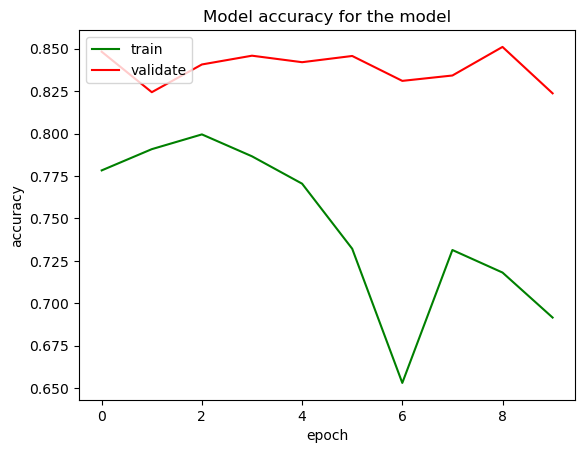

In [82]:
#Plot accuracy results for training data and testing data 
plt.plot(model_hist.history['sparse_categorical_accuracy'], 'green')
plt.plot(model_hist.history['val_sparse_categorical_accuracy'], 'red')
plt.title('Model accuracy for the model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')

188/188 [==============================] - 0s 1ms/step


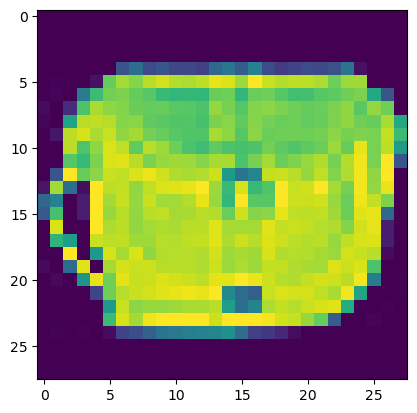

Model predicts: Bag - 8/8


In [83]:
check(model, X_test, 1)

In [85]:
# Recreate the exact same model, including its weights and the optimizer
my_model_v2 = tf.keras.models.load_model('my_model_v2.h5')
loss, acc = my_model_v2.evaluate(X_test, y_test, verbose=2)
results = my_model_v2.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

188/188 - 0s - loss: 0.3519 - sparse_categorical_accuracy: 0.8770 - 350ms/epoch - 2ms/step
47/47 [==============================] - 0s 2ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.8770
test loss, test acc: [0.3519418239593506, 0.8769999742507935]


# Conclusions
### Based on the tests - many iterations of the models (number of epochs, amount of "new data" (after augmentation), various operations related to augmentation, I can conclude:

- Dense and Flatten layers cannot cope with new augmentation data that is significantly altered (rotations or transposition made along an axis that is not the axis of symmetry), it may be related to the fact that these layers do not distinguish where the objects are located and their orientation,

- entering a large amount of augmented data has a negative effect on the model - noise is introduced,

- the increase in the precision of the prediction for the validation layer increases after adding the augmented set - in relation to the results in the training phase. Could this be because the model is less likely to overtrain with new data?

It seams that this model cannot learn more - it's too simple - due to its layers.

# Ultimately, I think there must be something better than Dense and Flatten layers for categorical prediction for photo sets :)